In [12]:
!pip uninstall binance
!pip install python-binance

^C


You should consider upgrading via the 'c:\users\deli91358\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [1]:
from backtesting import Strategy
from backtesting import Backtest
import talib
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from tqdm import tqdm
import ccxt
import plotly.graph_objects as go

C:\Users\deli91358\AppData\Local\Programs\Python\Python39\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

# Funtions

In [10]:
def candlestick_score(op, high, low, close):
    candle_names = talib.get_function_groups()['Pattern Recognition']
    candle_patterns = pd.DataFrame()
    i=0
    for candle in candle_names:
        if i==0:
            candle_patterns = pd.DataFrame({candle: getattr(talib, candle)(op, high, low, close)})
            i+=1
        else:    
            df = pd.DataFrame({candle: getattr(talib, candle)(op, high, low, close)})
            candle_patterns = candle_patterns.join(df)
    candle_patterns['score'] = candle_patterns.sum(axis=1)

    return candle_patterns['score']

# Strategies

### Build a 14 MA crossover simple strategy

## Candlestick patterns score

### Strategy

In [11]:
class CP_score(Strategy):
    '''
    Candlestick Pattern Score
    Compute a score that is positive if the candlestick patterns are bullish and negative when they are bearish
    
    1.0
    when the score becomes positive: go long
    when the score become negative: go short

    1.1
    when the score becomes better than the treshold: go long
    when the score become worst than the treshold: go short
    if the lost are more than the stop loss: sell position
    if the profit are more than the take profit: sell position
    '''
    # Class variables (for optimization)
    
    #score_treshold1 = 0 # candlestick pattern score treshold to buy
    #score_treshold2 = 0 # candlestick pattern score treshold to sell
    #sl_treshold = -0.05 # loss that triggers the stop loss
    #tp_treshold = 0.2 # Gains that triggers the take profit
    score_treshold1=-200
    score_treshold2=200
    sl_treshold=-0.1
    tp_treshold=0.2
    
    def init(self):
        # Precompute elements
        self.score = self.I(candlestick_score, self.data.Open, self.data.High,  self.data.Low, self.data.Close)
        self.inPosition = False
        self.positionType = None
        self.entryPrice = None
    
    def next(self):
        # long if score is positive and not already in a position
        if self.score > self.score_treshold1 and (self.inPosition==False or self.positionType == 'short'):
            self.position.close()
            self.buy()
            self.inPosition=True
            self.positionType = 'long'
            self.entryPrice = self.data.Close[-1]

        # short if score is negative and not already in a position
        elif self.score < -self.score_treshold2 and (self.inPosition==False or self.positionType == 'long'):
            self.position.close()
            self.sell()
            self.inPosition=True
            self.positionType = 'short'
            self.entryPrice = self.data.Close[-1]

        # check if the stop or take profit is triggered
        if self.inPosition:
            if self.positionType=='long':
                pnl = (self.data.Close[-1] - self.entryPrice) / self.entryPrice
                if pnl <= self.sl_treshold:
                    self.position.close()
                    self.inPosition=False
                    self.positionType = None
                elif pnl >= self.tp_treshold:
                    self.position.close()
                    self.inPosition=False
                    self.positionType = None
            if self.positionType=='short':
                pnl = (self.entryPrice - self.data.Close[-1]) / self.entryPrice
                if pnl <= self.sl_treshold:
                    self.position.close()
                    self.inPosition=False
                    self.positionType = None
                elif pnl >= self.tp_treshold:
                    self.position.close()
                    self.inPosition=False
                    self.positionType = None
            

        

### Backtest

In [20]:
ETH = yf.download(tickers='ETH-USD', period = '1y', interval = '1h')

bt1 = Backtest(ETH, CP_score, cash=1000000, commission=.002, trade_on_close=True)
stats = bt1.run()
stats

[*********************100%***********************]  1 of 1 completed


Start                     2020-11-10 01:00...
End                       2021-11-10 01:26...
Duration                    365 days 00:26:02
Exposure Time [%]                   99.965726
Equity Final [$]               3215724.621829
Equity Peak [$]                8083566.615917
Return [%]                         221.572462
Buy & Hold Return [%]               958.99306
Return (Ann.) [%]                  217.774908
Volatility (Ann.) [%]              499.788196
Sharpe Ratio                         0.435734
Sortino Ratio                        2.992373
Calmar Ratio                         3.219063
Max. Drawdown [%]                  -67.651639
Avg. Drawdown [%]                   -3.602228
Max. Drawdown Duration      185 days 03:00:00
Avg. Drawdown Duration        2 days 19:00:00
# Trades                                 1003
Win Rate [%]                        43.170489
Best Trade [%]                       21.42057
Worst Trade [%]                     -15.95083
Avg. Trade [%]                    

In [21]:
BTC = yf.download(tickers='BTC-USD', period = '1y', interval = '1h')

bt2 = Backtest(BTC, CP_score, cash=1000000, commission=.002, trade_on_close=True)
stats2 = bt2.run()
stats2

[*********************100%***********************]  1 of 1 completed


Start                     2020-11-10 01:00...
End                       2021-11-10 01:27...
Duration                    365 days 00:27:02
Exposure Time [%]                   99.977151
Equity Final [$]                650971.859307
Equity Peak [$]                2199745.193646
Return [%]                         -34.902814
Buy & Hold Return [%]              335.456391
Return (Ann.) [%]                  -34.675222
Volatility (Ann.) [%]               70.487222
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -78.629536
Avg. Drawdown [%]                   -4.417233
Max. Drawdown Duration      209 days 20:00:00
Avg. Drawdown Duration        5 days 19:00:00
# Trades                                 1041
Win Rate [%]                        38.424592
Best Trade [%]                       19.97908
Worst Trade [%]                    -14.488095
Avg. Trade [%]                    

In [80]:
stats = bt1.optimize(score_treshold1=range(-400, 400, 200),
                    score_treshold2=range(-400, 400, 200),
                    sl_treshold=[-0.05,-0.1,-0.15],
                    tp_treshold=[0.1,0.2,0.3],
                    maximize='Equity Final [$]')
stats

Start                     2020-11-09 03:00...
End                       2021-11-09 03:29...
Duration                    365 days 00:29:02
Exposure Time [%]                   99.965726
Equity Final [$]                 30880.264457
Equity Peak [$]                   74686.26623
Return [%]                         208.802645
Buy & Hold Return [%]              960.399041
Return (Ann.) [%]                    222.0654
Volatility (Ann.) [%]              486.125453
Sharpe Ratio                         0.456807
Sortino Ratio                        3.131958
Calmar Ratio                         3.348382
Max. Drawdown [%]                  -66.320202
Avg. Drawdown [%]                   -3.627181
Max. Drawdown Duration      184 days 05:00:00
Avg. Drawdown Duration        2 days 21:00:00
# Trades                                 1009
Win Rate [%]                        42.913776
Best Trade [%]                       21.42057
Worst Trade [%]                     -15.95083
Avg. Trade [%]                    

In [13]:
stats._strategy

<Strategy CP_score>

In [14]:
bt1.plot()

ValueError: Invalid value for `superimpose`: Upsampling not supported.

Text(0.5, 1.0, 'Time in Trades')

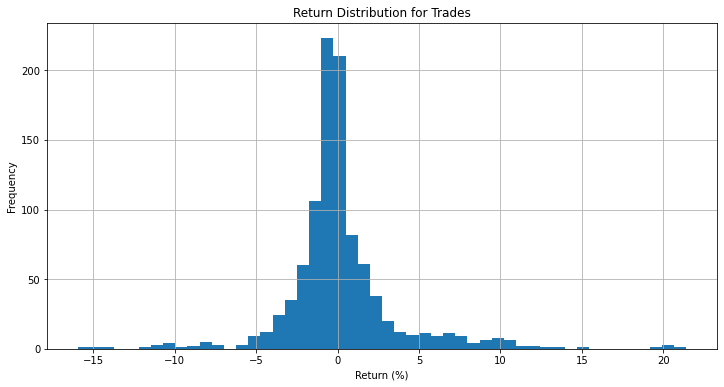

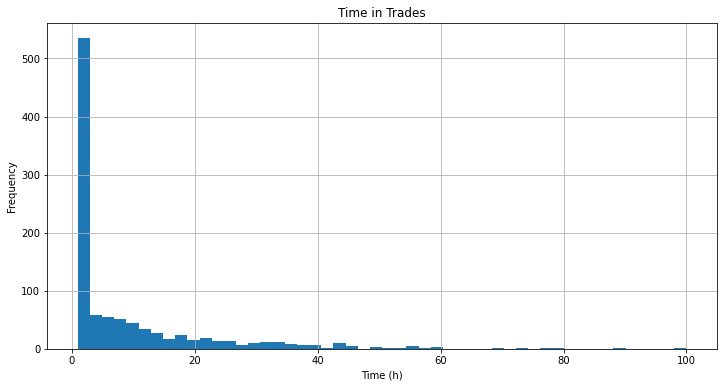

In [15]:
plt.figure(figsize=(12, 6))
(stats['_trades'].ReturnPct *100).hist(bins=50)
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.title('Return Distribution for Trades')

plt.figure(figsize=(12, 6))
(stats['_trades'].ExitBar-stats['_trades'].EntryBar).hist(bins=50)
plt.xlabel('Time (h)')
plt.ylabel('Frequency')
plt.title('Time in Trades')

In [16]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,22,1,30,446.581749,458.049255,252.285132,0.025678,2020-11-10 02:00:00+00:00,2020-11-11 08:00:00+00:00,1 days 06:00:00
1,-22,30,32,457.133157,462.396790,-115.799919,-0.011514,2020-11-11 08:00:00+00:00,2020-11-11 10:00:00+00:00,0 days 02:00:00
2,21,32,41,463.321583,467.438934,86.464375,0.008887,2020-11-11 10:00:00+00:00,2020-11-11 19:00:00+00:00,0 days 09:00:00
3,-21,41,43,466.504056,464.840179,34.941417,0.003567,2020-11-11 19:00:00+00:00,2020-11-11 21:00:00+00:00,0 days 02:00:00
4,22,43,46,465.769860,457.680725,-177.960964,-0.017367,2020-11-11 21:00:00+00:00,2020-11-12 00:00:00+00:00,0 days 03:00:00
...,...,...,...,...,...,...,...,...,...,...
998,6,8701,8715,4629.004178,4722.049316,558.270832,0.020100,2021-11-07 23:00:00+00:00,2021-11-08 13:00:00+00:00,0 days 14:00:00
999,-6,8715,8716,4712.605218,4713.633789,-6.171428,-0.000218,2021-11-08 13:00:00+00:00,2021-11-08 14:00:00+00:00,0 days 01:00:00
1000,6,8716,8736,4723.061057,4804.412109,488.106316,0.017224,2021-11-08 14:00:00+00:00,2021-11-09 10:00:00+00:00,0 days 20:00:00
1001,-6,8736,8738,4794.803285,4786.007812,52.772836,0.001834,2021-11-09 10:00:00+00:00,2021-11-09 12:00:00+00:00,0 days 02:00:00


Look at what happens after in the hours following us entering our trades

In [58]:
# calculate the 1, 2, 3, 4, 5 h returns for all points
df = ETH.copy()
n = 15
columns = ['t+' + str(i) + ' return' for i in range(1,n)]
i = 0
for column in columns:
    i+=1
    df[column] = df['Close'].pct_change(periods=i)
    df[column] = df[column].shift(-1)

# Link the returns to the trades
df_trades = df.iloc[stats['_trades'].EntryBar.to_list()]



In [59]:
df

,Open,High,Low,Close,Adj Close,Volume,t+1 return,t+2 return,t+3 return,t+4 return,t+5 return,t+6 return,t+7 return,t+8 return,t+9 return,t+10 return,t+11 return,t+12 return,t+13 return,t+14 return
2019-11-09 01:00:00+00:00,184.935898,185.058365,184.733017,184.934433,184.934433,0,-0.001011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-09 02:00:00+00:00,184.880356,185.117264,184.699615,184.747421,184.747421,0,-0.000146,-0.001157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-09 03:00:00+00:00,184.733139,185.029510,184.538849,184.720490,184.720490,5833728,-0.000562,-0.000708,-0.001718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-09 04:00:00+00:00,184.718674,184.733994,184.364182,184.616669,184.616669,0,0.001829,0.001266,0.001120,0.000108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-09 05:00:00+00:00,184.623657,185.101837,184.565033,184.954346,184.954346,0,0.003850,0.005686,0.005121,0.004974,0.003958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-08 22:00:00+00:00,4773.278320,4781.055664,4760.075684,4779.309082,4779.309082,0,0.005388,0.006409,0.008965,0.010476,0.005491,0.004701,0.007099,0.007327,0.019396,0.017580,0.012993,0.015193,0.014517,0.016408
2021-11-08 23:00:00+00:00,4781.719238,4805.061035,4766.497070,4805.061035,4805.061035,416362496,-0.003184,0.002187,0.003205,0.005752,0.007258,0.002289,0.001502,0.003893,0.004120,0.016150,0.014339,0.009768,0.011960,0.011287
2021-11-09 00:00:00+00:00,4810.071289,4811.639160,4783.044434,4789.760742,4789.760742,214005760,-0.000153,-0.003336,0.002034,0.003051,0.005599,0.007105,0.002136,0.001349,0.003739,0.003966,0.015995,0.014185,0.009613,0.011806
2021-11-09 01:00:00+00:00,4792.217773,4792.217773,4783.691406,4789.029785,4789.029785,84385792,-0.000151,-0.000303,-0.003487,0.001883,0.002900,0.005447,0.006953,0.001985,0.001198,0.003588,0.003815,0.015842,0.014032,0.009461


In [60]:
for column in columns:
    df_trades[column + ' name'] = column
    
df_trades

<ipython-input-60-027aff7a2505>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,High,Low,Close,Adj Close,Volume,t+1 return,t+2 return,t+3 return,t+4 return,...,t+5 return name,t+6 return name,t+7 return name,t+8 return name,t+9 return name,t+10 return name,t+11 return name,t+12 return name,t+13 return name,t+14 return name
2019-11-09 14:00:00+00:00,185.172073,185.214447,184.706161,184.706161,184.706161,0,-0.002778,-0.005140,-0.004478,-0.003085,...,t+5 return,t+6 return,t+7 return,t+8 return,t+9 return,t+10 return,t+11 return,t+12 return,t+13 return,t+14 return
2019-11-09 21:00:00+00:00,184.917969,185.389236,184.917969,185.303619,185.303619,0,0.000074,0.002445,0.003849,0.002852,...,t+5 return,t+6 return,t+7 return,t+8 return,t+9 return,t+10 return,t+11 return,t+12 return,t+13 return,t+14 return
2019-11-11 06:00:00+00:00,189.220978,189.220978,187.070206,187.070206,187.070206,0,0.001424,-0.010131,-0.011685,-0.011250,...,t+5 return,t+6 return,t+7 return,t+8 return,t+9 return,t+10 return,t+11 return,t+12 return,t+13 return,t+14 return
2019-11-11 19:00:00+00:00,186.657669,186.761627,186.332092,186.688034,186.688034,23264256,-0.002365,-0.002234,0.000366,-0.001133,...,t+5 return,t+6 return,t+7 return,t+8 return,t+9 return,t+10 return,t+11 return,t+12 return,t+13 return,t+14 return
2019-11-12 13:00:00+00:00,187.231628,187.231628,186.341888,186.341888,186.341888,0,-0.008136,-0.012457,-0.009194,-0.010162,...,t+5 return,t+6 return,t+7 return,t+8 return,t+9 return,t+10 return,t+11 return,t+12 return,t+13 return,t+14 return
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20 18:00:00+01:00,4078.183350,4079.189697,4054.690186,4075.908447,4075.908447,170432512,0.012140,0.011627,0.011575,0.019244,...,t+5 return,t+6 return,t+7 return,t+8 return,t+9 return,t+10 return,t+11 return,t+12 return,t+13 return,t+14 return
2021-11-01 14:00:00+00:00,4377.322266,4377.322266,4324.672852,4324.672852,4324.672852,0,0.005232,-0.005331,-0.000323,0.007262,...,t+5 return,t+6 return,t+7 return,t+8 return,t+9 return,t+10 return,t+11 return,t+12 return,t+13 return,t+14 return
2021-11-02 04:00:00+00:00,4320.321289,4370.390625,4318.907227,4363.799805,4363.799805,0,-0.000069,0.009774,0.011770,0.008562,...,t+5 return,t+6 return,t+7 return,t+8 return,t+9 return,t+10 return,t+11 return,t+12 return,t+13 return,t+14 return
2021-11-02 07:00:00+00:00,4375.937012,4378.835938,4343.613281,4343.613281,4343.613281,0,0.003854,-0.003549,-0.000721,-0.000789,...,t+5 return,t+6 return,t+7 return,t+8 return,t+9 return,t+10 return,t+11 return,t+12 return,t+13 return,t+14 return


In [61]:
fig = go.Figure()
for column in columns:
    fig.add_trace(go.Violin(x=df_trades[column + ' name'],
                            y=df_trades[column],
                            name=column,
                            box_visible=True,
                            meanline_visible=True))

fig.show()

### Conclusion

The strategy is not very robust.

## Buy the hottest coin in X last minutes/hours/days

### Get the symbols and the price data

In [4]:
from binance.client import Client

# connect to binance client
client = Client()

# get exchange info (huge dictionnary)
info = client.get_exchange_info()

# get all symbols on exchange
all_symbols = [x['symbol'] for x in info['symbols']]
print('There is <' + str(len(all_symbols)) + '> symbols on the binance exchange.')

# exclude leveraged tokens
excludes = ['UP', 'DOWN', 'BEAR', 'BULL']
non_lev_symbols = [symbol for symbol in all_symbols if all(exclude not in symbol for exclude in excludes)]
print('There is <' + str(len(non_lev_symbols)) + '> non-leveraged symbols on the binance exchange.')

# keep only assets related to usdt
relevant_symbols = [symbol for symbol in non_lev_symbols if symbol.endswith('USDT')]
print('There is <' + str(len(relevant_symbols)) + '> non-leveraged symbols with a USDT base on the binance exchange.')

There is <1772> symbols on the binance exchange.
There is <1709> non-leveraged symbols on the binance exchange.
There is <305> non-leveraged symbols with a USDT base on the binance exchange.


### Return the n largest winners in the last hour

In [9]:
klines = {}
klines_columns = ['Open time','Open','High','Low','Close','Volume','Close time','Quote asset volume','Numberklines_columns of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore']
for symbol in tqdm(relevant_symbols):
    klines[symbol] = client.get_historical_klines(symbol, '1m', '5 minutes ago UTC')


returns, symbols = [], []
for symbol in relevant_symbols:
    if len(klines[symbol]) > 0:
        cumulative_return = (pd.DataFrame(klines[symbol])[4].astype(float).pct_change()+1).prod()-1
        returns.append(cumulative_return)
        symbols.append(symbol)

return_df = pd.DataFrame(returns, index=symbols, columns=['cum_return'])
return_df.cum_return.nlargest(10)

100%|██████████| 305/305 [01:43<00:00,  2.95it/s]


MBLUSDT      0.012210
YFIIUSDT     0.010181
STORJUSDT    0.005928
CELRUSDT     0.003342
KP3RUSDT     0.002586
ANTUSDT      0.002554
RGTUSDT      0.002461
ENSUSDT      0.001611
CRVUSDT      0.001430
TOMOUSDT     0.001180
Name: cum_return, dtype: float64

In [7]:
return_df

,cum_return
BTCUSDT,0.009663
ETHUSDT,0.016918
BNBUSDT,0.014104
NEOUSDT,0.006510
LTCUSDT,0.020741
...,...
ENSUSDT,0.018449
KP3RUSDT,0.021214
QIUSDT,-0.039672
PORTOUSDT,0.012523


In [29]:
# get 3 hours of 1 minute klines for all symbols
klines = {}
for symbol in tqdm(relevant_symbols):
    klines[symbol] = client.get_historical_klines(symbol, '1m', '3 hour ago UTC')

100%|██████████| 301/301 [01:46<00:00,  2.84it/s]


In [35]:
# get the best performing coin in each 60 minutes, the return in the last hours and the minute data for the next hour
returns, symbols = [], []
results = [] 
window = 60
number_window = 3
for i in tqdm(range(window, window*(number_window-1)-1)): # rolling 60 loop
    for symbol in relevant_symbols: # symbols loop
        if len(klines[symbol]) > 0:
            cumulative_return = (pd.DataFrame(klines[symbol])[4].iloc[i:i+window].astype(float).pct_change()+1).prod()-1 # cumreturns in the last window
            time = pd.DataFrame(klines[symbol])[0].iloc[i+window] # time at which we measure the returns
            results.append((time, symbol, cumulative_return))

df_returns = pd.DataFrame(results, columns=['Time', 'Symbol', 'Cumulative Ret. 60 min'])
df_returns = df_returns.set_index('Symbol')

100%|██████████| 59/59 [00:40<00:00,  1.47it/s]


In [51]:


fig = go.Figure()
n=0
last_best_symbol = 0
for time in df_returns.Time.unique():
    best_symbol = df_returns[df_returns.Time == time]['Cumulative Ret. 60 min'].idxmax()
    #print(best_symbol, )
    if last_best_symbol != best_symbol:
        df_best = pd.DataFrame(klines[best_symbol])
        df_best = df_best[df_best[0] >= time]
        #y = (df_best[4].astype(float).pct_change()+1).cumprod()
        y = df_best[4].astype(float).pct_change()
        x = [i for i in range(n, len(df_best[4])-1)]

        fig.add_trace(go.Scatter(x=x, y=y,
                        mode='lines',
                        name=best_symbol))
        last_best_symbol = best_symbol
        

    n+=1


fig.show()


# plot the 60 minutes after the buy for each of the 60 minutes (should have 60)

NULSUSDT
IOTXUSDT
IOTXUSDT
IOTXUSDT
IOTXUSDT
IOTXUSDT
IOTXUSDT
IOTXUSDT
IOTXUSDT
IOTXUSDT
IOTXUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CTSIUSDT
CTSIUSDT
CTSIUSDT
CTSIUSDT
CTSIUSDT
CHRUSDT
CTSIUSDT
CTSIUSDT
CTSIUSDT
CTSIUSDT
CTSIUSDT
CTSIUSDT
CHRUSDT
CHRUSDT
CTSIUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
CHRUSDT
ENSUSDT


In [47]:
n

61